In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image;
import glob 

Choose to train the neural network or to load the weights

In [2]:
train = True

Load images and resize them in to (150,150) shape 

In [3]:
image_shape = 150
image_list = []
for filename in glob.glob('CNRPark-Patches-150x150/*/busy/*.jpg'):
    temp =Image.open(filename)
    im = temp.resize((image_shape,image_shape), Image.NEAREST)
    image_list.append(im)
    temp.close()

images_busy = np.empty((len(image_list),image_shape,image_shape,3), dtype="int")
for i in range(len(image_list)):
    images_busy[i] = np.asarray(image_list[i])

image_list = []
for filename in glob.glob('CNRPark-Patches-150x150/*/free/*.jpg'): 
    temp =Image.open(filename)
    im = temp.resize((image_shape,image_shape), Image.NEAREST)
    image_list.append(im)
    temp.close()

images_free = np.empty((len(image_list),image_shape,image_shape,3), dtype="int")
for i in range(len(image_list)):
    images_free[i] = np.asarray(image_list[i])   

print("number of busy parking slot images: " + str(len(images_busy)))
print("number of free parking slot images: " + str(len(images_free)))

number of busy parking slot images: 8402
number of free parking slot images: 4182


In [4]:
images = np.concatenate((images_busy,images_free), axis=0)
print("size of the images set: " + str(len(images)))


size of the images set: 12584


Definition of labels

In [5]:
label = np.empty(len(images), dtype="object")
label[0:len(images_busy)] = "busy"
label[len(images_busy):] = "free"
labels = np.empty(len(images))
labels[0:len(images_busy)] = 1
labels[len(images_busy):] = 0
print(label)

['busy' 'busy' 'busy' ... 'free' 'free' 'free']


Random permutation and plot few images to check data

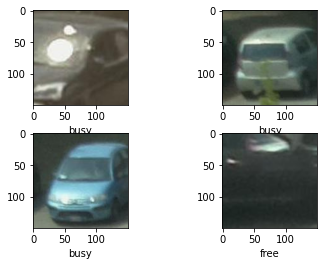

In [6]:
permutation = np.random.permutation(len(images)) # random permutation
images = images[permutation]
label = label[permutation]
labels = labels[permutation]

img = images[0:4]

fig, axes = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i,ax in enumerate(axes.flat):
    ax.imshow(img[i])
    ax.set_xlabel(label[i])

Definition of training and test set

In [7]:
ind =int(len(images)*0.8)
image_training = images[:ind]
label_training = labels[:ind]
image_test = images[ind:]
label_test = labels[ind:]
print("training set size is: " + str(len(image_training)))
print("test set size is: " + str(len(image_test)))

training set size is: 10067
test set size is: 2517


Input Tensor

In [8]:
image_shape = 150
input = keras.layers.Input(shape=(image_shape, image_shape,3), name='input0')

Set up the layers

In [9]:
# Convolutional Layer 1.
kernel_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully connected layer.
fc_size = 64            # Number of neurons in fully-connected layer.

In [10]:
conv1 = keras.layers.Conv2D(filters = num_filters1, kernel_size=kernel_size1, strides=(1, 1), padding='same', 
                            data_format='channels_last',activation=tf.nn.relu, use_bias=True,
                            kernel_initializer='glorot_uniform', bias_initializer='zeros', name='conv1')(input)
                            
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', 
                                  data_format='channels_last', name='pool1')(conv1)

conv2 = keras.layers.Conv2D(filters = num_filters2, kernel_size=filter_size2, strides=(1, 1), padding='same', 
                            data_format='channels_last', activation=tf.nn.relu, input_shape=(image_shape, image_shape),
                            use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', name='conv2')(pool1)
                            
pool2 = keras.layers.MaxPooling2D(pool_size=(5, 5), strides=None, padding='valid', data_format='channels_last', name='pool2')(conv2)

flat = keras.layers.Flatten()(pool2)

fc1 = keras.layers.Dense(fc_size, activation=tf.nn.relu, 
                         kernel_initializer='glorot_uniform', bias_initializer='zeros', name='fc1')(flat)
                         
output = keras.layers.Dense(2, activation=tf.nn.softmax, 
                            kernel_initializer='glorot_uniform', bias_initializer='zeros', name='fc2')(fc1)

In [11]:
model = keras.models.Model(inputs=[input], outputs=[output])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input0 (InputLayer)         [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 150, 150, 16)      1216      
                                                                 
 pool1 (MaxPooling2D)        (None, 75, 75, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 75, 75, 36)        14436     
                                                                 
 pool2 (MaxPooling2D)        (None, 15, 15, 36)        0         
                                                                 
 flatten (Flatten)           (None, 8100)              0         
                                                                 
 fc1 (Dense)                 (None, 64)                518464

Compile the model

In [13]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\gianm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
if (not train):
    load_path = 'log/model_ep10'
    if load_path:
        model.load_weights(load_path)
        print('Load trained weights from {}'.format(load_path))

Train model

In [15]:
if (train):
    history = model.fit(image_training, label_training, batch_size = 128, epochs=10, validation_split = 0.3)

Epoch 1/10
56/56 [==============================] - 91s 2s/step - loss: 10.3872 - accuracy: 0.7705 - val_loss: 0.2406 - val_accuracy: 0.8964
Epoch 2/10
56/56 [==============================] - 90s 2s/step - loss: 0.1502 - accuracy: 0.9377 - val_loss: 0.1276 - val_accuracy: 0.9540
Epoch 3/10
56/56 [==============================] - 105s 2s/step - loss: 0.0779 - accuracy: 0.9679 - val_loss: 0.0932 - val_accuracy: 0.9656
Epoch 4/10
56/56 [==============================] - 146s 3s/step - loss: 0.0699 - accuracy: 0.9750 - val_loss: 0.0601 - val_accuracy: 0.9798
Epoch 5/10
56/56 [==============================] - 156s 3s/step - loss: 0.0365 - accuracy: 0.9865 - val_loss: 0.0664 - val_accuracy: 0.9815
Epoch 6/10
56/56 [==============================] - 158s 3s/step - loss: 0.0479 - accuracy: 0.9821 - val_loss: 0.0937 - val_accuracy: 0.9656
Epoch 7/10
56/56 [==============================] - 156s 3s/step - loss: 0.0301 - accuracy: 0.9881 - val_loss: 0.0533 - val_accuracy: 0.9851
Epoch 8/10
56/

History data: loss, accuracy, val_loss, val_accuracy


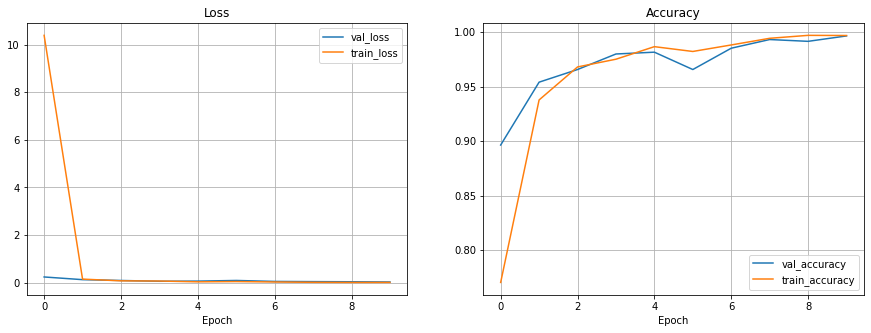

In [16]:
if (train):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))

    print('History data: '+', '.join(history.history.keys()))
    key_list = list(history.history.keys())

    axes[0].plot(history.history[key_list[2]], label=key_list[2])
    axes[0].plot(history.history[key_list[0]], label='train_' + key_list[0])
    axes[0].grid('both')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    axes[1].plot(history.history[key_list[3]], label=key_list[3])
    axes[1].plot(history.history[key_list[1]], label='train_' + key_list[1])
    axes[1].grid('both')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()

    plt.show()

Save model weights

In [17]:
if (train):
    save_path = 'log/model_ep{}'.format(len(history.history['loss']))
    if save_path:
        model.save_weights(save_path)
        print('Saved trained weights at {}'.format(save_path))

Saved trained weights at log/model_ep10


Evaluate test error

In [18]:
if (train):
    test_loss, test_acc = model.evaluate(image_test, label_test)
    print('Test accuracy:', test_acc)

79/79 [==============================] - 15s 190ms/step - loss: 0.0218 - accuracy: 0.9944
Test accuracy: 0.9944378137588501


Load my frames and predict the corresponding labels

In [41]:
name_list = []
image_list = []
for filename in glob.glob('frames/*.jpg'):
    temp =Image.open(filename)
    im = temp.resize((image_shape,image_shape), Image.NEAREST)
    image_list.append(im)
    name_list.append(filename)
    temp.close()

my_images = np.empty((len(image_list),image_shape,image_shape,3), dtype="int")

for i in range(len(image_list)):
    my_images[i] = np.asarray(image_list[i])
    
prediction = model.predict(my_images)

1/1 [==============================] - 0s 132ms/step


Write results in results.txt

In [42]:
results = np.empty(len(image_list),dtype='int')
with open('results.txt', 'w') as f:
    for i in range(len(prediction)):
        results[i] = np.argmax(prediction[i])
        f.write(str(results[i]))
        f.write(',' + name_list[i][name_list[i].find('_')-3:name_list[i].find('_')] + '.')
print(results)


[1 0 1 0 0 0 0 0 0]
